# QC for Human genome 92

## Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

## Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_5968\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


## QC workflow

In [13]:
adatas = []
data_names = ['control','lf','lps','pic']
main_path = '/Code/data/single_cell/animals/human/'
paths = ['\\control','\\lf','\\lps','\\pic']    #...etc - Folders with matrix, features and barcodes gz files.
for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)    # use gene symbols for the variable names (variables-axis index)
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)

    reading \Code\data\single_cell\animals\human\control\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.89 GB, difference -0.04 GB
(5329, 58395)
    reading \Code\data\single_cell\animals\human\lf\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 1.15 GB, difference +0.27 GB
(6193, 58395)
    reading \Code\data\single_cell\animals\human\lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 1.11 GB, difference -0.04 GB
(4615, 58395)
    reading \Code\data\single_cell\animals\human\pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 1.32 GB, difference +0.21 GB
(5015, 58395)


In [14]:
adata = adatas[0].concatenate(adatas[1:], batch_categories=data_names, batch_key='treatment')

adata

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 21152 × 58395
    obs: 'treatment'
    var: 'gene_ids', 'feature_types'

In [16]:
genes = pd.read_csv('/Code/data/single_cell/animals/human_mart.csv')
genes.dropna(subset = ['gene_id'], inplace=True)

genes_dict = dict(zip(genes['gene_id'].astype('str'), genes.eggnog_name.astype('str')))

dict_multi, dict_uni = {}, {}
for d in genes_dict:
    if len(d.split(',')) != 1:
        dict_multi[d] = genes_dict[d]
    else:
        dict_uni[d] =  genes_dict[d]

multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))

    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni, **multi_result_dict}

genes_dict

{'ENSG00000210049': 'MT-TF',
 'ENSG00000211459': 'MT-RNR1',
 'ENSG00000210077': 'MT-TV',
 'ENSG00000210082': 'MT-RNR2',
 'ENSG00000209082': 'MT-TL1',
 'ENSG00000198888': 'MT-ND1',
 'ENSG00000210100': 'MT-TI',
 'ENSG00000210107': 'MT-TQ',
 'ENSG00000210112': 'MT-TM',
 'ENSG00000198763': 'MT-ND2',
 'ENSG00000210117': 'MT-TW',
 'ENSG00000210127': 'MT-TA',
 'ENSG00000210135': 'MT-TN',
 'ENSG00000210140': 'MT-TC',
 'ENSG00000210144': 'MT-TY',
 'ENSG00000198804': 'MT-CO1',
 'ENSG00000210151': 'MT-TS1',
 'ENSG00000210154': 'MT-TD',
 'ENSG00000198712': 'MT-CO2',
 'ENSG00000210156': 'MT-TK',
 'ENSG00000228253': 'MT-ATP8',
 'ENSG00000198899': 'MT-ATP6',
 'ENSG00000198938': 'MT-CO3',
 'ENSG00000210164': 'MT-TG',
 'ENSG00000198840': 'MT-ND3',
 'ENSG00000210174': 'MT-TR',
 'ENSG00000212907': 'MT-ND4L',
 'ENSG00000198886': 'MT-ND4',
 'ENSG00000210176': 'MT-TH',
 'ENSG00000210184': 'MT-TS2',
 'ENSG00000210191': 'MT-TL2',
 'ENSG00000198786': 'MT-ND5',
 'ENSG00000198695': 'MT-ND6',
 'ENSG00000210194': 

In [17]:
adata.var

,gene_ids,feature_types
DDX11L1,ENSG00000223972,Gene Expression
WASH7P,ENSG00000227232,Gene Expression
MIR6859-1,ENSG00000278267,Gene Expression
MIR1302-2HG,ENSG00000243485,Gene Expression
MIR1302-2,ENSG00000284332,Gene Expression
...,...,...
AC240274.1,ENSG00000271254,Gene Expression
RF00003-14,ENSG00000275405,Gene Expression
RF00003-15,ENSG00000275987,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [18]:
adata.var.set_index('gene_ids', inplace=True) 
adata.var['gene_ids'] = adata.var.index

adata.var.drop(columns='feature_types', inplace=True)
adata.var.rename(genes_dict, inplace=True)

In [19]:
adata.var

,gene_ids
gene_ids,
DDX11L1,ENSG00000223972
WASH7P,ENSG00000227232
MIR6859-1,ENSG00000278267
MIR1302-2HG,ENSG00000243485
MIR1302-2,ENSG00000284332
...,...
nan,ENSG00000271254
U1,ENSG00000275405
U1,ENSG00000275987


In [20]:
# This code identifies duplicate variable names, iterates through them, and adds suffixes to make them unique from the first occurrence.
# Please make sure to replace adata with your actual AnnData object.

# Keep in mind that Scanpy's functionality may evolve, so it's a good idea to check the documentation or release notes
# for any updates related to making variable names unique starting from the first occurrence in more recent versions of Scanpy.

# Get a Series of variable (gene) names
var_names_series = pd.Series(adata.var_names)

# Identify duplicate variable names
duplicate_var_names = var_names_series[var_names_series.duplicated(keep='first')]

# Iterate through duplicates and add suffixes to make them unique from the first occurrence
for duplicate_name in duplicate_var_names:
    count = 1
    indices = var_names_series[var_names_series == duplicate_name].index
    for idx in indices:
        var_names_series[idx] = f'{duplicate_name}_{count}'
        count += 1

# Update the AnnData object with the unique variable names
adata.var_names = var_names_series.values

adata.var_names

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'OR4G4P', 'OR4G11P', 'OR4F5', 'nan_1',
       ...
       'nan_15743', 'nan_15744', 'nan_15745', 'nan_15746', 'nan_15747',
       'nan_15748', 'U1_5', 'U1_6', 'nan_15749', 'nan_15750'],
      dtype='object', length=58395)

## Genes and cells filtration 

### Highly expressed genes ( = top 20 genes)

normalizing counts per cell
    finished (0:00:00)


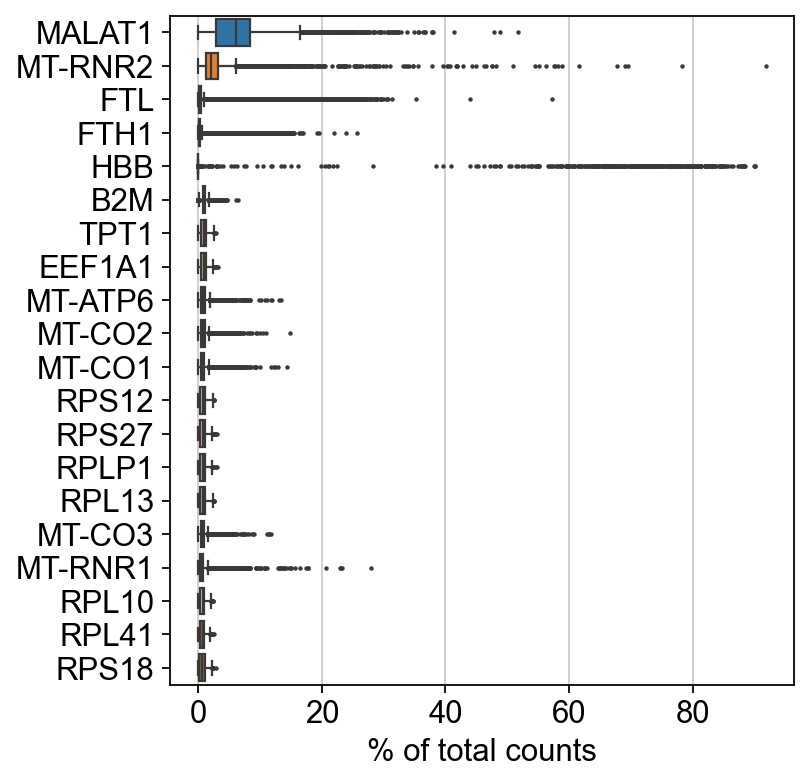

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [22]:
sc.pp.filter_cells(adata, min_genes=100) 
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

filtered out 330 cells that have less than 100 genes expressed
filtered out 30411 genes that are detected in less than 3 cells
(20822, 27984)


### Mitochondrial QC and general measures
Check if genes are annotated as mt by running:
- GENES= list(adata.var.index[adata.var.index.str.startswith('mt-'.upper())])
- GENES

In case the genes are not annotated as 'MT-'' (Like in bats), run:

- dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2'...etc}
- adata.var.rename(dict_replace, inplace = True)

In [23]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata.var.rename(dict_replace, inplace=True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [24]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [25]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

### Scatter plots of QC metrics

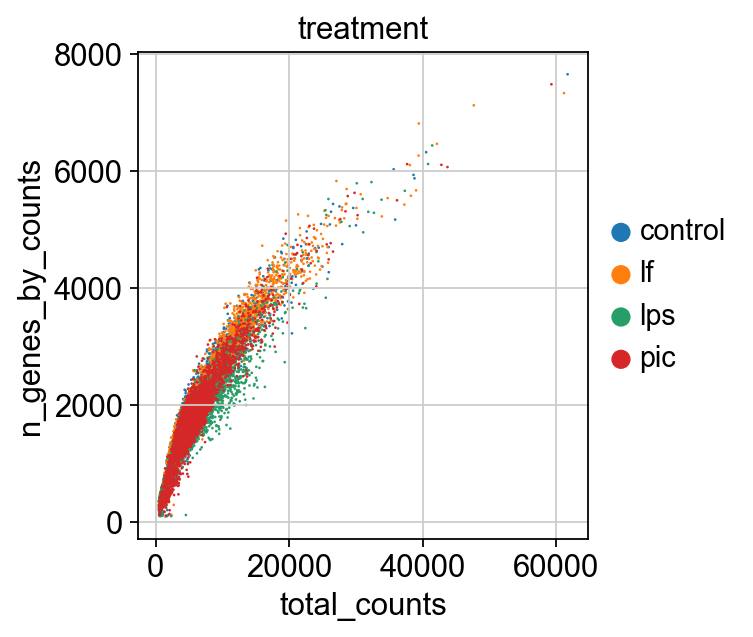

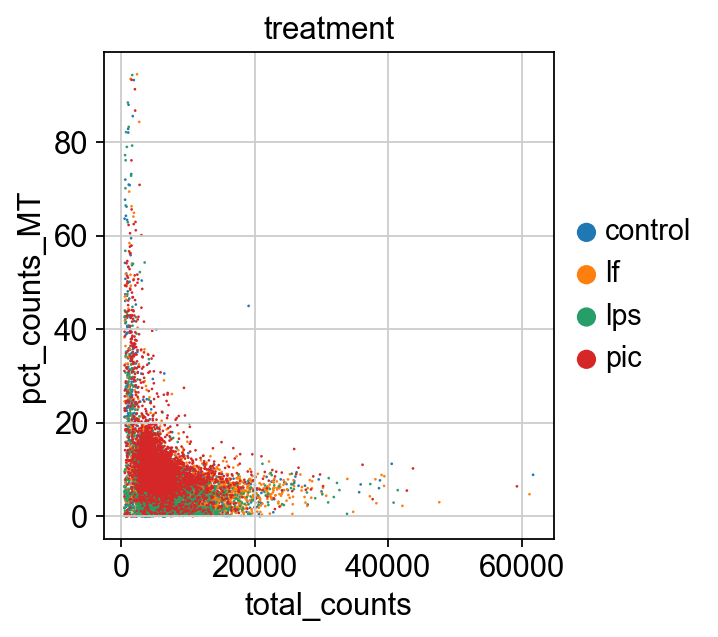

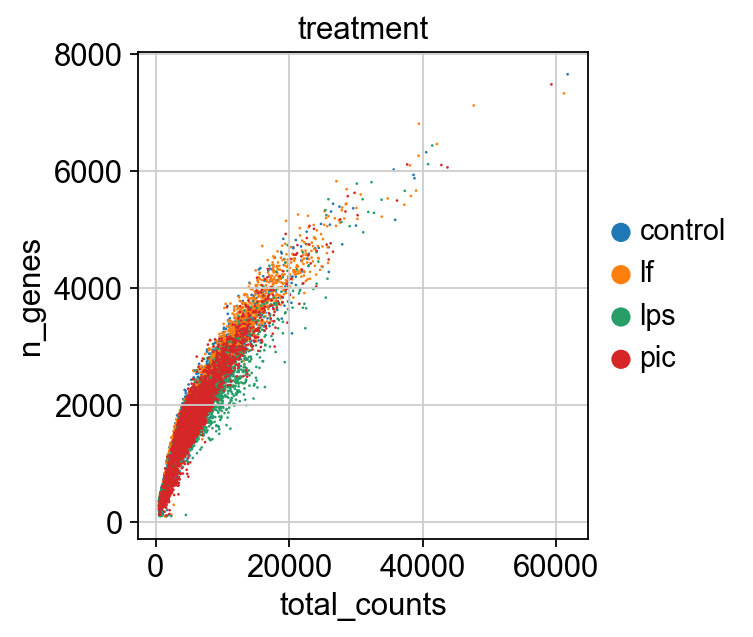

In [26]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='treatment', save=True)

In [28]:
adata = adata[adata.obs.pct_counts_MT < 20] 
adata = adata[adata.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

## Doublet analysis and filtering

In [35]:
import scrublet as scr

def scrub(adatas, adata, adata_names):  # based on raw individual samples. 
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data,name in zip(adatas, adata_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)

    adata = adata[adata.obs.index.isin(doub_index)]
    print('After scrublet: ', adata.shape[0])
    return adata

Before scrublet:  10375
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.17
Detected doublet rate = 60.2%
Estimated detectable doublet fraction = 89.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 67.4%
Elapsed time: 5.7 seconds
Doubletscontrol : 1942
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.17
Detected doublet rate = 47.3%
Estimated detectable doublet fraction = 88.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 53.6%
Elapsed time: 6.6 seconds
Doubletslf : 1554
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 71.5%
Estimated detectable doublet fraction = 92.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 77.3%
Elapsed time: 4.4 seconds
Doubletslps : 1603
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 79.2%
Estimated detectable doublet fraction = 95.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 83.3%
Elapsed time: 6.5 seconds
Doubletspic : 2196
After scrublet:  6608


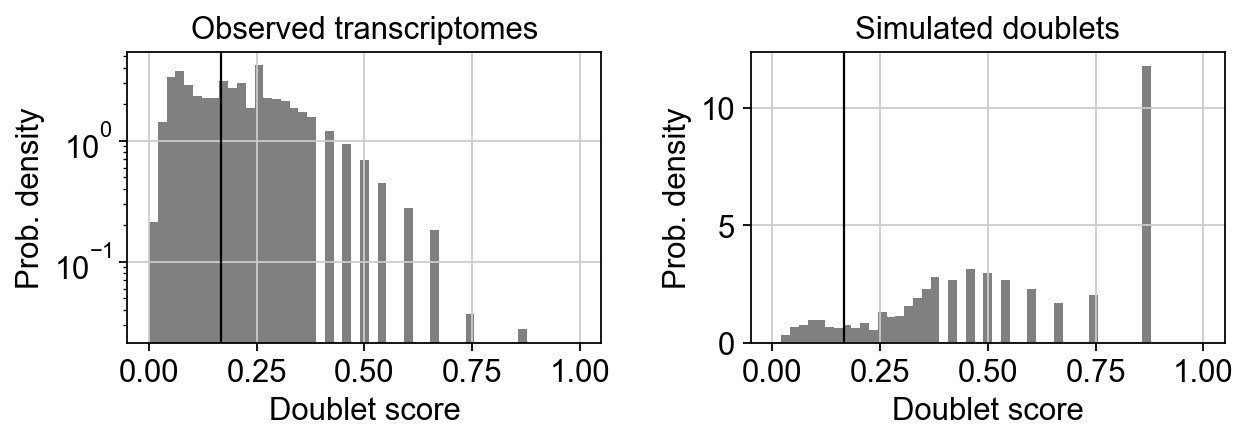

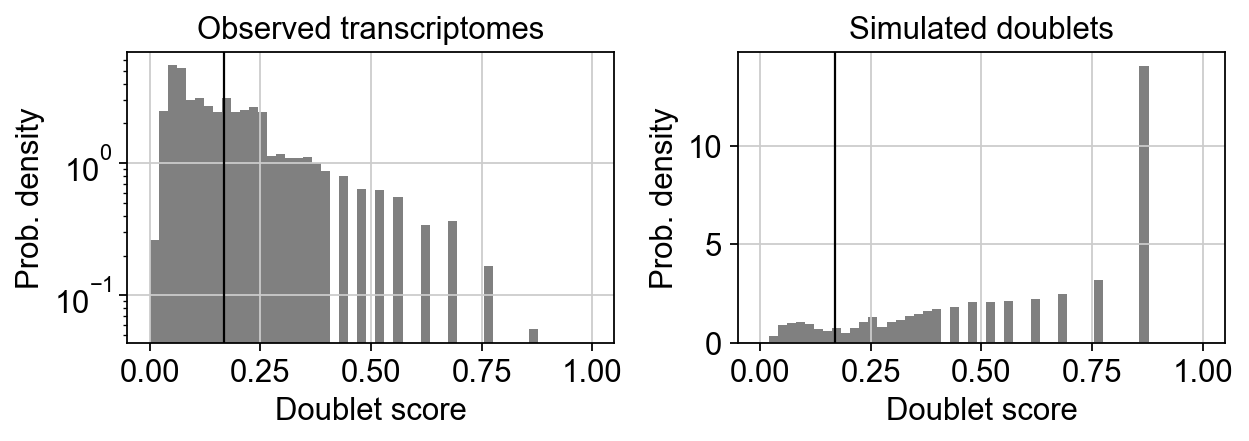

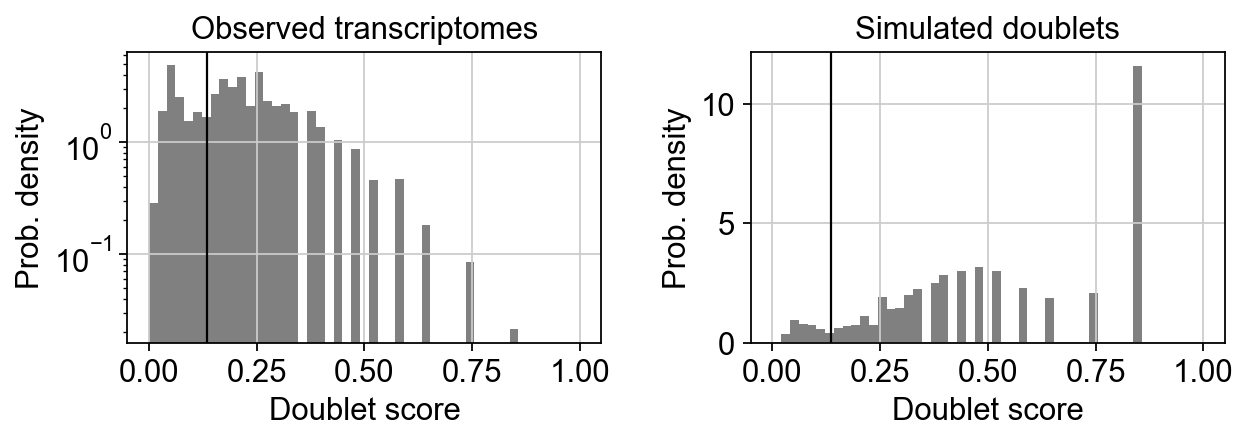

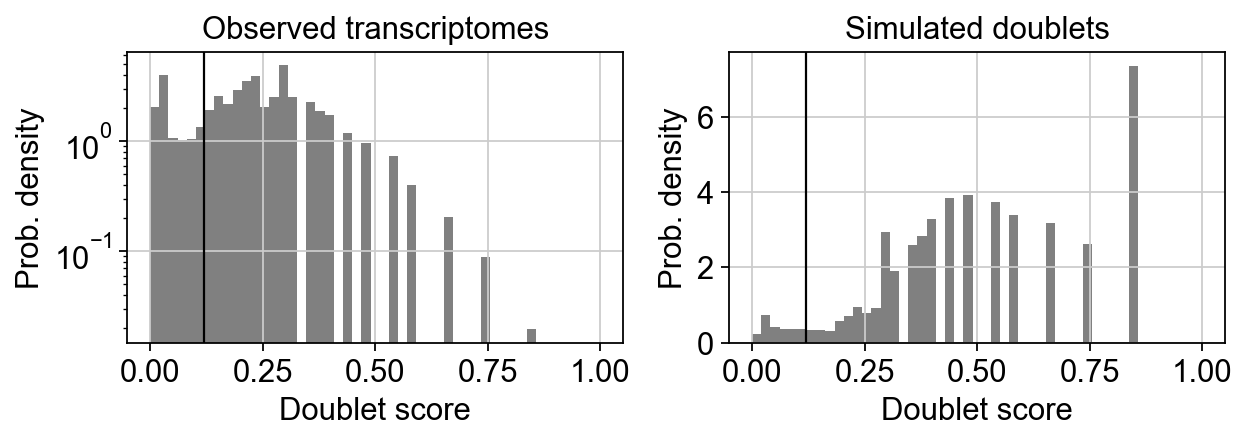

In [36]:
adata = scrub(adatas, adata, data_names)

## Cell cycle scoring
download Cell cycle txt: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt

In [37]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [38]:
adata.var_names

Index(['nan_1', 'nan_2', 'CICP27', 'nan_3', 'nan_4', 'nan_6', 'nan_7', 'nan_8',
       'nan_10', 'nan_11',
       ...
       'nan_15726', 'nan_15727', 'MAFIP', 'nan_15728', 'nan_15731',
       'nan_15734', 'nan_15739', 'nan_15742', 'nan_15746', 'nan_15748'],
      dtype='object', length=27984)

In [39]:
g2m_genes

['HMGB2',
 'CDK1',
 'NUSAP1',
 'UBE2C',
 'BIRC5',
 'TPX2',
 'TOP2A',
 'NDC80',
 'CKS2',
 'NUF2',
 'CKS1B',
 'MKI67',
 'TMPO',
 'CENPF',
 'TACC3',
 'SMC4',
 'CCNB2',
 'CKAP2L',
 'CKAP2',
 'AURKB',
 'BUB1',
 'KIF11',
 'ANP32E',
 'TUBB4B',
 'GTSE1',
 'KIF20B',
 'HJURP',
 'CDCA3',
 'CDC20',
 'TTK',
 'KIF2C',
 'RANGAP1',
 'NCAPD2',
 'DLGAP5',
 'CDCA2',
 'CDCA8',
 'ECT2',
 'KIF23',
 'HMMR',
 'AURKA',
 'PSRC1',
 'ANLN',
 'LBR',
 'CKAP5',
 'CENPE',
 'CTCF',
 'NEK2',
 'G2E3',
 'GAS2L3',
 'CBX5',
 'CENPA']

In [40]:
matching_values = adata.var_names.isin(cell_cycle_genes)

matching_values

array([False, False, False, ..., False, False, False])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    837 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    922 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


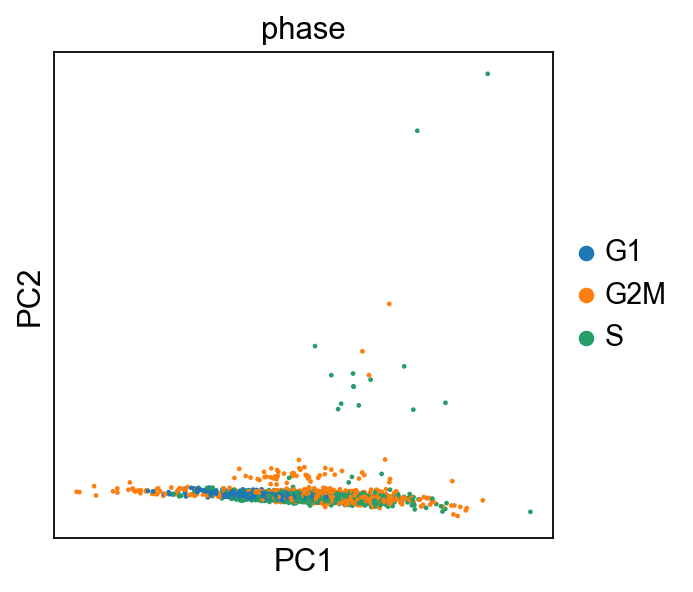

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_5968\1917813240.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()


In [41]:
cell_cycle_adata = adata.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

In [42]:
adata

AnnData object with n_obs × n_vars = 6608 × 27984
    obs: 'treatment', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'treatment_colors'

## Saving adata

In [43]:
adata.write(r'/Code/data/single_cell/animals/human/''human_after_qc.h5ad')

## Preparing files to be opened in R studio

In [ ]:
# # Preparing files to be opened in R studio

# matrix_dense = adata.X.toarray()

# # Create a DataFrame from the dense array with observation names as index and variable names as columns
# matrix_df = pd.DataFrame(matrix_dense, index=adata.obs_names, columns=adata.var_names)

# # Save the DataFrame to a CSV file
# matrix_df.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''matrix_new.csv')
# print('matrix file is transformed')

# #save obs as scv
# adata.obs.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''obs_new.csv')
# print('obs file is transformed')

# # Save variable data to a CSV file
# adata.var.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''var_new.csv')
# print('var file is transformed')